### Imports

In [1]:
# All necessary imports 
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, DetCurveDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
from collections import Counter


# Fixing pandas columns display and hiding warnings
pd.set_option("display.max_columns", 500)
warnings.filterwarnings("ignore")

### File Reading

In [2]:
# Reading the file
path = r"C:\Users\motil\Desktop\ML\NBA_players_clean.csv"
clean = pd.read_csv(path)

In [3]:
clean.head()

,Player,From,To,Years,Pos,Ht,Height,Wt,G,PTS,TRB,AST,FG%,FG3%,FT%,eFG%,PER,WS,All Star,All NBA,All ABA,All Rookie,All Defensive,BLK Champ,STL Champ,TRB Champ,AST Champ,Scoring Champ,Most Improved,Sixth Man,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team
0,Alaa Abdelnaby,1991,1995,5,F-C,6-10,6.833333,240.0,256,5.7,3.3,0.3,50.2,0.0,70.1,50.2,13.0,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Zaid Abdul-Aziz,1969,1978,10,F-C,6-9,6.750000,235.0,505,9.0,8.0,1.2,42.8,17.7,72.8,48.4,15.1,17.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kareem Abdul-Jabbar*,1970,1989,20,C,7-2,7.166667,225.0,1560,24.6,11.2,3.6,55.9,5.6,72.1,55.9,24.6,273.4,19,15,0,1,11,4,0,1,0,2,0,0,0,1,0,0,2,6,6,1,0
3,Mahmoud Abdul-Rauf,1991,2001,11,G,6-1,6.083333,162.0,586,14.6,1.9,3.5,44.2,35.4,90.5,47.2,15.4,25.2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Tariq Abdul-Wahad,1998,2003,6,F,6-6,6.500000,223.0,236,7.8,3.3,1.1,41.7,23.7,70.3,42.2,11.4,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Preprocessing

In [4]:
# Copying clean DataFrame to new dataframe
df = clean.copy()

In [5]:
# Extracting target variable from "Player" field
df["hof"] = df.Player.str.contains("*", regex=False).astype('int')
df[["Player", "hof"]].head()

,Player,hof
0,Alaa Abdelnaby,0
1,Zaid Abdul-Aziz,0
2,Kareem Abdul-Jabbar*,1
3,Mahmoud Abdul-Rauf,0
4,Tariq Abdul-Wahad,0


In [6]:
# Droping all records of active and recently retired players
hofs = df.loc[df["hof"] == 1]
max_to_df = df["To"].max()
max_to_hofs = hofs["To"].max()
records_after_max_to_hofs = clean["To"] > max_to_hofs

print("Maximum 'To' in dataset:", max_to_df)
print("Maximum 'To' of Hall of Famers:", max_to_hofs)

print("Number of records in dataset:", len(clean))
print(f"Number of records to drop (records after {max_to_hofs}):", records_after_max_to_hofs.sum())

df = df.loc[df["To"] <= max_to_hofs]
df.shape

Maximum 'To' in dataset: 2022
Maximum 'To' of Hall of Famers: 2018
Number of records in dataset: 5023
Number of records to drop (records after 2018): 884


(4139, 40)

In [7]:
print(df.columns.tolist())

['Player', 'From', 'To', 'Years', 'Pos', 'Ht', 'Height', 'Wt', 'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 'eFG%', 'PER', 'WS', 'All Star', 'All NBA', 'All ABA', 'All Rookie', 'All Defensive', 'BLK Champ', 'STL Champ', 'TRB Champ', 'AST Champ', 'Scoring Champ', 'Most Improved', 'Sixth Man', 'DPOY', 'ROY', 'AS MVP', 'CF MVP', 'Finals MVP', 'MVP', 'Championships', 'NBA 75 Team', 'ABA All-Time Team', 'hof']


In [8]:
# Uniting All NBA and All ABA columns to one column.
# Both fields have the same professional effect
df["All NBA/ABA"] = df["All NBA"] + df["All ABA"]

In [9]:
# Dropping unneceserray columns
df = df.drop(columns=["To", "Ht", "All NBA", "All ABA", "Player"])
print(df.columns.tolist())

['From', 'Years', 'Pos', 'Height', 'Wt', 'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 'eFG%', 'PER', 'WS', 'All Star', 'All Rookie', 'All Defensive', 'BLK Champ', 'STL Champ', 'TRB Champ', 'AST Champ', 'Scoring Champ', 'Most Improved', 'Sixth Man', 'DPOY', 'ROY', 'AS MVP', 'CF MVP', 'Finals MVP', 'MVP', 'Championships', 'NBA 75 Team', 'ABA All-Time Team', 'hof', 'All NBA/ABA']


In [10]:
# Generating dummy variables from "Pos" field 
df = pd.get_dummies(df, columns=["Pos"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4139 entries, 0 to 5022
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   From               4139 non-null   int64  
 1   Years              4139 non-null   int64  
 2   Height             4139 non-null   float64
 3   Wt                 4139 non-null   float64
 4   G                  4139 non-null   int64  
 5   PTS                4139 non-null   float64
 6   TRB                4139 non-null   float64
 7   AST                4139 non-null   float64
 8   FG%                4139 non-null   float64
 9   FG3%               4139 non-null   float64
 10  FT%                4139 non-null   float64
 11  eFG%               4139 non-null   float64
 12  PER                4139 non-null   float64
 13  WS                 4139 non-null   float64
 14  All Star           4139 non-null   int64  
 15  All Rookie         4139 non-null   int64  
 16  All Defensive      4139 

### Descriptive Statistics

In [11]:
# Displaying basic descriptive statistics
df.describe()

,From,Years,Height,Wt,G,PTS,TRB,AST,FG%,FG3%,FT%,eFG%,PER,WS,All Star,All Rookie,All Defensive,BLK Champ,STL Champ,TRB Champ,AST Champ,Scoring Champ,Most Improved,Sixth Man,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team,hof,All NBA/ABA,Pos_C,Pos_F,Pos_F-C,Pos_G,Pos_G-F
count,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.0,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000
mean,1982.268181,5.177338,6.493316,208.034574,269.923411,6.158227,2.994588,1.365402,40.340686,22.707224,69.093791,44.780647,11.035902,13.288983,0.357574,0.087461,0.108722,0.008215,0.008215,0.014013,0.014255,0.014738,0.006040,0.006765,0.006282,0.016187,0.016912,0.0,0.009664,0.014979,0.190143,0.015221,0.007248,0.039623,0.193283,0.113071,0.284368,0.134574,0.342353,0.125634
std,19.865341,4.534755,0.304709,26.253524,312.299788,4.610998,2.259760,1.313423,10.548983,13.135040,13.908363,8.460111,6.281900,25.888967,1.560508,0.282543,0.799510,0.153673,0.126025,0.256000,0.262051,0.244861,0.077492,0.090392,0.120251,0.126211,0.173676,0.0,0.153589,0.210337,0.695799,0.122446,0.084837,0.195096,1.123519,0.316718,0.451167,0.341309,0.474554,0.331477
min,1947.000000,1.000000,5.250000,114.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-52.700000,-10.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1968.000000,1.000000,6.250000,188.600000,31.000000,2.800000,1.400000,0.500000,35.900000,15.400000,62.800000,43.500000,9.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1983.000000,3.000000,6.500000,206.000000,122.000000,5.000000,2.400000,1.000000,41.800000,23.400000,71.000000,45.400000,11.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1999.000000,8.000000,6.750000,225.000000,453.000000,8.400000,3.900000,1.900000,46.200000,28.600000,77.400000,48.400000,13.700000,15.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,2018.000000,23.000000,7.583333,360.000000,1611.000000,30.100000,22.900000,11.200000,100.000000,100.000000,100.000000,150.000000,88.300000,273.400000,19.000000,1.000000,15.000000,4.000000,3.000000,11.000000,9.000000,10.000000,1.000000,2.000000,4.000000,1.000000,4.000000,0.0,6.000000,6.000000,11.000000,1.000000,1.000000,1.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Displaying pairwise correlation of field
df.corr()

,From,Years,Height,Wt,G,PTS,TRB,AST,FG%,FG3%,FT%,eFG%,PER,WS,All Star,All Rookie,All Defensive,BLK Champ,STL Champ,TRB Champ,AST Champ,Scoring Champ,Most Improved,Sixth Man,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team,hof,All NBA/ABA,Pos_C,Pos_F,Pos_F-C,Pos_G,Pos_G-F
From,1.000000,0.123624,0.323094,0.368547,0.039495,-0.133971,-0.222715,-0.091682,0.265532,0.025204,0.052747,-0.043273,-0.049835,-0.018275,-0.071368,0.079089,0.002363,0.010677,0.011572,-0.025782,-0.023899,-0.028982,0.051066,0.032904,0.019831,-0.037588,-0.042571,NaN,-0.002513,-0.027393,-0.030475,-0.047876,-0.053062,-0.119594,-0.062535,0.081179,0.065045,-0.113784,0.056216,-0.129419
Years,0.123624,1.000000,0.150230,0.111205,0.947807,0.671562,0.514258,0.528435,0.378108,0.082425,0.266424,0.282156,0.383992,0.769414,0.423853,0.405669,0.284496,0.122404,0.120081,0.117972,0.128634,0.123223,0.125550,0.151536,0.121157,0.205680,0.197787,NaN,0.156800,0.168993,0.365980,0.273680,0.116637,0.328582,0.339101,-0.016489,-0.152931,0.200984,-0.066737,0.112504
Height,0.323094,0.150230,1.000000,0.827849,0.118589,-0.019960,0.352010,-0.384260,0.293711,-0.304517,-0.188392,0.079213,0.055945,0.102845,0.051700,0.081177,0.049276,0.100950,-0.033182,0.062645,-0.047735,0.025073,0.018768,0.017728,0.053359,0.043136,0.012792,NaN,0.040539,0.062835,0.041236,0.035653,0.000317,0.016991,0.032952,0.511784,0.225067,0.300080,-0.688179,-0.119090
Wt,0.368547,0.111205,0.827849,1.000000,0.072493,-0.051742,0.304124,-0.369532,0.254176,-0.270054,-0.201193,0.075772,0.052965,0.066474,0.030194,0.063805,0.015824,0.051024,-0.045809,0.056524,-0.042751,0.010409,0.014508,0.009779,0.041267,0.039871,0.012168,NaN,0.040192,0.042050,0.022394,0.020585,-0.011180,0.001525,0.024852,0.486584,0.221629,0.241964,-0.610243,-0.142068
G,0.039495,0.947807,0.118589,0.072493,1.000000,0.741087,0.574969,0.583191,0.365660,0.084428,0.280837,0.284061,0.405690,0.846758,0.480445,0.443461,0.326835,0.126645,0.128616,0.135365,0.136778,0.130289,0.115114,0.159529,0.127722,0.228366,0.218139,NaN,0.165189,0.187883,0.390203,0.310224,0.146590,0.376190,0.377156,-0.032769,-0.148492,0.204478,-0.064011,0.114516
PTS,-0.133971,0.671562,-0.019960,-0.051742,0.741087,1.000000,0.649820,0.666252,0.344155,0.122591,0.334516,0.289837,0.512894,0.765431,0.587870,0.505364,0.250070,0.063647,0.141405,0.142761,0.113753,0.245343,0.113991,0.111769,0.073389,0.335568,0.323956,NaN,0.214423,0.247052,0.304177,0.376377,0.230709,0.460808,0.489302,-0.099875,-0.146779,0.150250,-0.028174,0.180835
TRB,-0.222715,0.514258,0.352010,0.304124,0.574969,0.649820,1.000000,0.246429,0.261442,-0.136861,0.028833,0.252935,0.420640,0.604069,0.445810,0.339610,0.240049,0.131028,0.044622,0.279224,0.043960,0.168422,0.054698,0.063474,0.129610,0.300344,0.226153,NaN,0.151106,0.273656,0.266641,0.310260,0.162690,0.374106,0.367349,0.140713,-0.009323,0.439416,-0.411950,0.015555
AST,-0.091682,0.528435,-0.384260,-0.369532,0.583191,0.666252,0.246429,1.000000,0.171725,0.203849,0.317789,0.151275,0.323689,0.562717,0.413912,0.335258,0.230633,0.010628,0.224949,0.061672,0.290291,0.116103,0.094891,0.070365,0.039323,0.211995,0.247290,NaN,0.158472,0.166157,0.239375,0.286376,0.123704,0.342037,0.361609,-0.194678,-0.295986,-0.053816,0.363381,0.124054
FG%,0.265532,0.378108,0.293711,0.254176,0.365660,0.344155,0.261442,0.171725,1.000000,-0.029012,0.097755,0.721493,0.597118,0.289493,0.145466,0.171385,0.093395,0.044441,0.033359,0.046394,0.025903,0.042599,0.041560,0.049435,0.044263,0.083726,0.064943,NaN,0.056854,0.063908,0.127587,0.084479,0.057187,0.101856,0.105503,0.083872,0.002814,0.122530,-0.149193,0.003459
FG3%,0.025204,0.082425,-0.304517,-0.270054,0.084428,0.122591,-0.136861,0.203849,-0.029012,1.000000,0.176153,0.154374,0.090119,0.068808,0.032162,0.071139,0.003379,-0.034199,0.035323,-0.018917,0.032828,0.001860,0.036710,0.041033,-0.016522,0.000994,0.011366,NaN,0.004793,-0.009154,0.017701,0.022816,-0.008852,0.019211,0.025844,-0.256504,-0.032289,-0.183031,0.233330,0.143447


In [13]:
# Displaying top 10 field correlated with "hof"
df.corr()[["hof"]].sort_values("hof", ascending=False).head(11)

,hof
hof,1.000000
All Star,0.759924
All NBA/ABA,0.669555
NBA 75 Team,0.612068
WS,0.597446
PTS,0.460808
AS MVP,0.429545
Championships,0.423370
G,0.376190
TRB,0.374106


### Visualisations

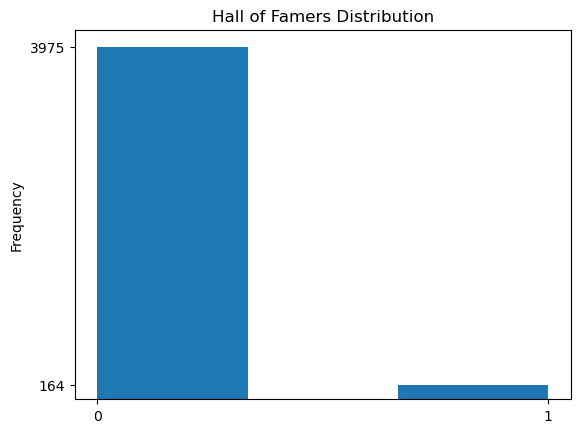

In [14]:
# Displaying Hall of Famers distribution
df["hof"].plot(
    kind="hist",
    title="Hall of Famers Distribution",
    bins=3,
    xticks=[0, 1],
    yticks=df["hof"].value_counts()
)
plt.show()

In [15]:
# Creating funvtions for plotting columns and correlation with "hof"
# count plot plotting
def plot_countplot(col, title):
    sns.countplot(
        x=col,
        hue="hof",
        data=df,
        log=True
    )
    # Add a title
    plt.title(title)
    # Show the plot
    plt.show()
    
def plot_scatterplot(col, title):
    sns.scatterplot(
        x=col,
        y=col,
        hue="hof",
        data=df
    )
    # Add a title
    plt.title(title)
    # Show the plot
    plt.show()

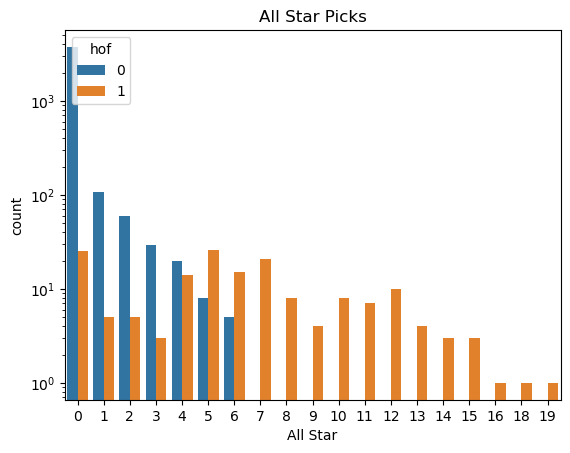

In [16]:
# Create a count plot for the "All Star" column
plot_countplot("All Star", "All Star Picks")

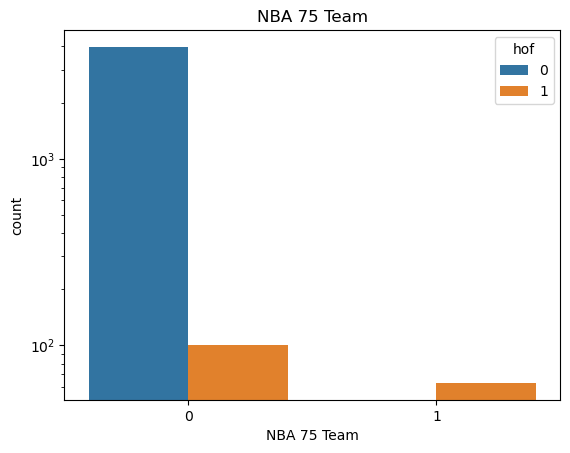

In [17]:
# Create a count plot for the "NBA 75 Team" column
plot_countplot("NBA 75 Team", "NBA 75 Team")

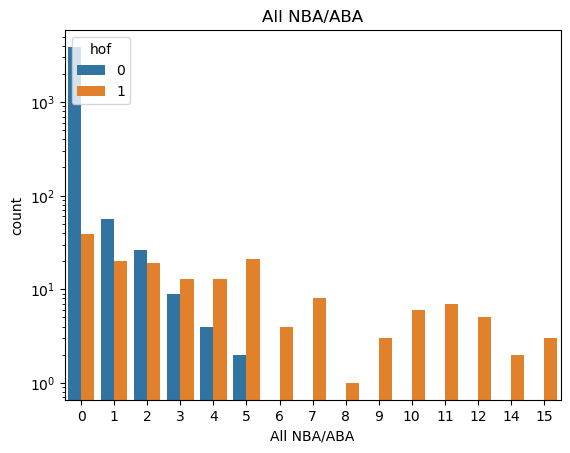

In [18]:
# Create a count plot for the "All NBA/ABA" column
plot_countplot("All NBA/ABA", "All NBA/ABA")

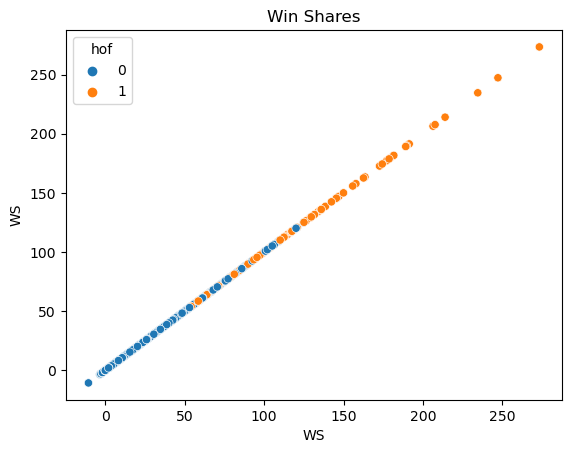

In [19]:
# Create a linear scatter plot for the "WS" column
plot_scatterplot("WS", "Win Shares")

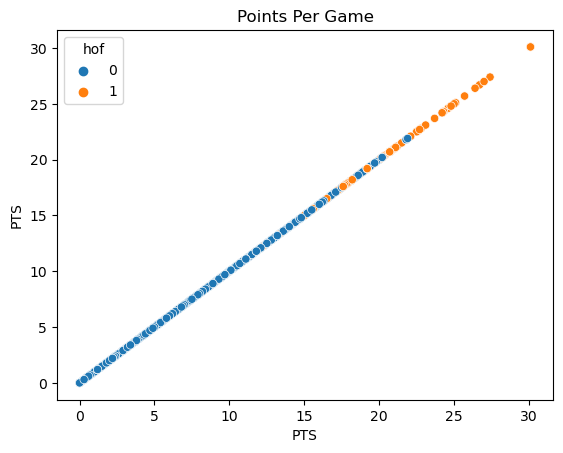

In [20]:
# Create a linear scatter plot for the "PTS" column
plot_scatterplot("PTS", "Points Per Game")

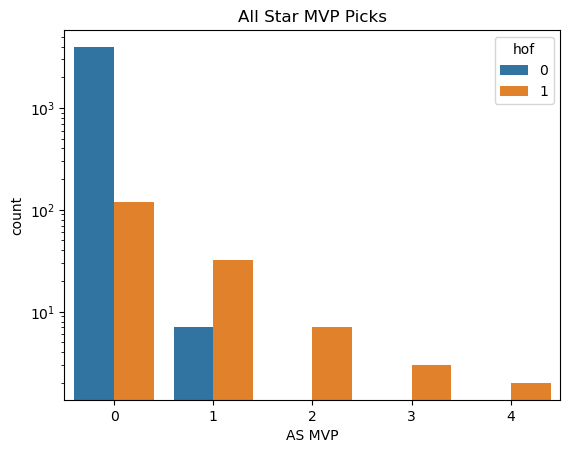

In [21]:
# Create a count plot for the "AS MVP" column
plot_countplot("AS MVP", "All Star MVP Picks")

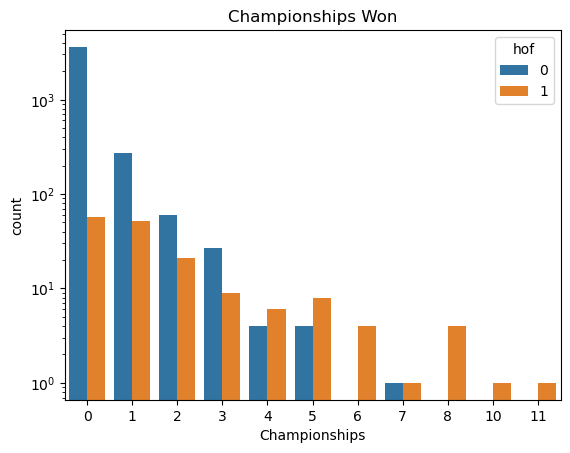

In [22]:
# Create a count plot for the "Championships" column
plot_countplot("Championships", "Championships Won")

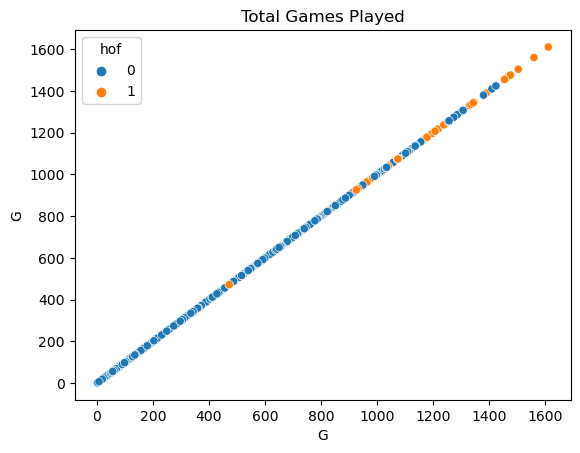

In [23]:
# Create a linear scatter plot for the "G" column
plot_scatterplot("G", "Total Games Played")

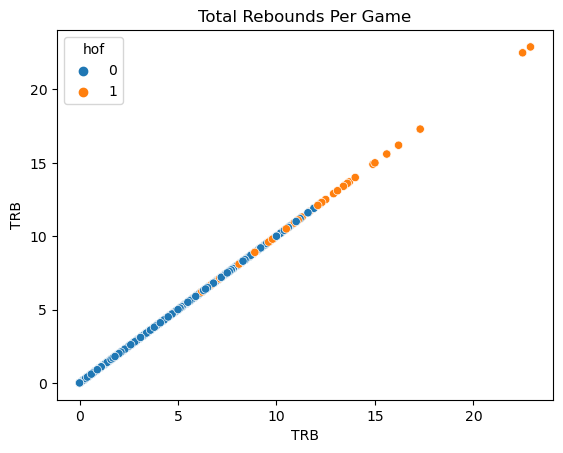

In [24]:
# Create a linear scatter plot for the "TRB" column
plot_scatterplot("TRB", "Total Rebounds Per Game")

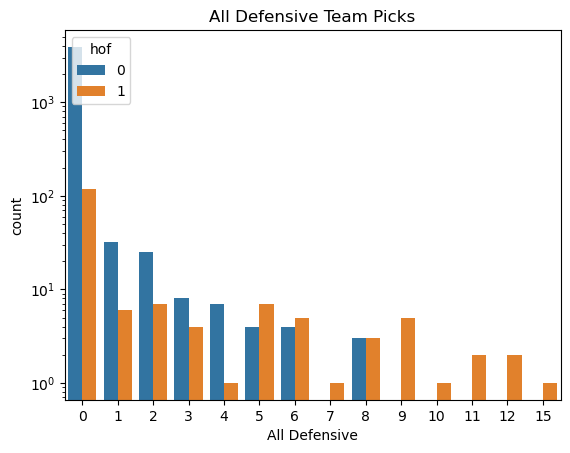

In [25]:
# Create a count plot for the "All Defensive" column
plot_countplot("All Defensive", "All Defensive Team Picks")

### Preprocessing for Model Fitting

In [26]:
# Creating X and y for model inputs
X = df.drop(columns=["hof"])
y = df["hof"]

In [27]:
# Scaling X fields
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

In [28]:
# Splitting to train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.25,
    stratify=y
)

### Basic Classifiers

In [29]:
# Running basic classification models

# Running Random Forest Classifier
rfc_clf = RandomForestClassifier()
rfc_clf.fit(x_train,y_train)
rfc_y_pred = rfc_clf.predict(x_test)

# Running SVM Classifier
svc_clf = SVC(class_weight="balanced",probability=True)
svc_clf.fit(x_train,y_train)
svc_y_pred = svc_clf.predict(x_test)

print("***** Basic Random Forest Classifier *****")
print()
print(classification_report(y_test, rfc_y_pred))
print(confusion_matrix(y_test, rfc_y_pred))
print()

print("***** Basic SVM Classifier *****")
print()
print(classification_report(y_test, svc_y_pred))
print(confusion_matrix(y_test, svc_y_pred))
print()

***** Basic Random Forest Classifier *****

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       994
           1       0.94      0.71      0.81        41

    accuracy                           0.99      1035
   macro avg       0.96      0.85      0.90      1035
weighted avg       0.99      0.99      0.99      1035

[[992   2]
 [ 12  29]]

***** Basic SVM Classifier *****

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       994
           1       0.52      0.83      0.64        41

    accuracy                           0.96      1035
   macro avg       0.75      0.90      0.81      1035
weighted avg       0.97      0.96      0.97      1035

[[962  32]
 [  7  34]]



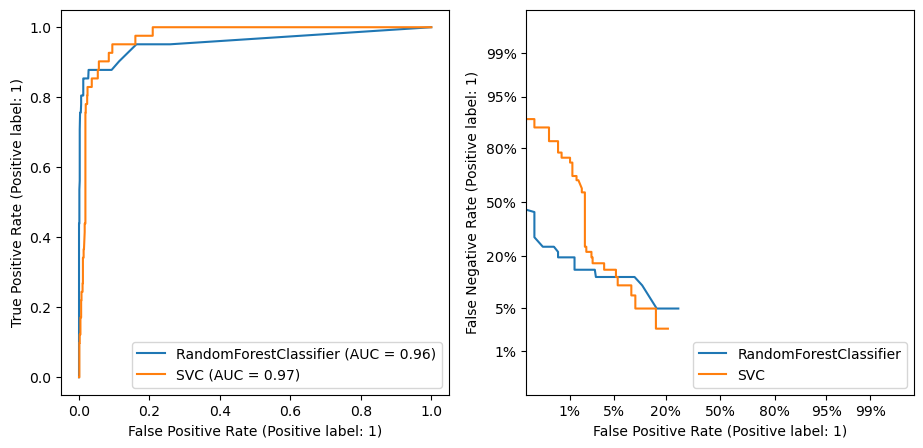

In [30]:
# Displaying DET and ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rfc_y_pred)
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(rfc_clf, x_test, y_test, ax=ax_roc)
DetCurveDisplay.from_estimator(rfc_clf, x_test, y_test, ax=ax_det)
RocCurveDisplay.from_estimator(svc_clf, x_test, y_test ,ax=ax_roc)
DetCurveDisplay.from_estimator(svc_clf, x_test, y_test, ax=ax_det)
plt.show()

### Classifiers Using GridSearchCV

In [31]:
# Creating Random Forest parametrs dictionary for GridSearchCV
tree_param_grid = {
    "n_estimators": [100*i for i in range (1,6)],
    "criterion": ["gini", "entropy", "log_loss"]
}

# Create a GridSearchCV object
rfc_gscv = GridSearchCV(
    RandomForestClassifier(),
    tree_param_grid,
    cv=3,
    scoring="recall_weighted"
)

# Fit the GridSearchCV to the training data
rfc_gscv.fit(x_train, y_train)
rfc_gscv_y_pred = rfc_gscv.predict(x_test)

# Print the best parameters and score
print("***** GridSearch Random Forest Classifier *****")
print()
print(f"Best parameters: {rfc_gscv.best_params_}")
print(classification_report(y_test, rfc_gscv_y_pred))
print(confusion_matrix(y_test, rfc_gscv_y_pred))

***** GridSearch Random Forest Classifier *****

Best parameters: {'criterion': 'entropy', 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       994
           1       0.94      0.71      0.81        41

    accuracy                           0.99      1035
   macro avg       0.96      0.85      0.90      1035
weighted avg       0.99      0.99      0.99      1035

[[992   2]
 [ 12  29]]


In [32]:
# Creating SVM parametrs dictionary for GridSearchCV
svc_param_grid = {
    "C": [0.0, 0.5, 1.0, 1.5, 2.0],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [2,3,4,5]
}

# Create a GridSearchCV object
svc_gscv = GridSearchCV(
    SVC(class_weight="balanced",probability=True),
    svc_param_grid,
    cv=3,
    scoring="recall_weighted"
)

# Fit the GridSearchCV to the training data
svc_gscv.fit(x_train, y_train)
svc_gscv_y_pred = svc_gscv.predict(x_test)

# Print the best parameters and metrics
print("***** GridSearch SVM Classifier *****")
print()
print(f"Best parameters: {svc_gscv.best_params_}")
print(classification_report(y_test, svc_gscv_y_pred))
print(confusion_matrix(y_test, svc_gscv_y_pred))

***** GridSearch SVM Classifier *****

Best parameters: {'C': 0.5, 'degree': 5, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       994
           1       0.83      0.73      0.78        41

    accuracy                           0.98      1035
   macro avg       0.91      0.86      0.89      1035
weighted avg       0.98      0.98      0.98      1035

[[988   6]
 [ 11  30]]


### Undersampling

In [33]:
rus = RandomUnderSampler(random_state=2)
x_resampled, y_resampled = rus.fit_resample(X,y)
x_resampled_train, x_resampled_test, y_resampled_train, y_resampled_test = train_test_split(x_resampled, y_resampled, test_size=0.25,stratify=y_resampled)

In [34]:
np.average(y_resampled_train),np.average(y_resampled_test)

(0.5, 0.5)

In [35]:
# Running basic classification models on resampled data

# Running Random Forest Classifier
resampled_rfc_clf = RandomForestClassifier()
resampled_rfc_clf.fit(x_resampled_train,y_resampled_train)
resampled_rfc_y_pred = resampled_rfc_clf.predict(x_resampled_test)

# Running SVM Classifier
resampled_svc_clf = SVC(class_weight="balanced",probability=True)
resampled_svc_clf.fit(x_resampled_train,y_resampled_train)
resampled_svc_y_pred = resampled_svc_clf.predict(x_resampled_test)

print("***** Basic Random Forest Classifier *****")
print()
print(classification_report(y_resampled_test, resampled_rfc_y_pred))
print(confusion_matrix(y_resampled_test, resampled_rfc_y_pred))
print()

print("***** Basic SVM Classifier *****")
print()
print(classification_report(y_resampled_test, resampled_svc_y_pred))
print(confusion_matrix(y_resampled_test, resampled_svc_y_pred))
print()

***** Basic Random Forest Classifier *****

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        41
           1       0.90      0.88      0.89        41

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82

[[37  4]
 [ 5 36]]

***** Basic SVM Classifier *****

              precision    recall  f1-score   support

           0       0.77      0.80      0.79        41
           1       0.79      0.76      0.77        41

    accuracy                           0.78        82
   macro avg       0.78      0.78      0.78        82
weighted avg       0.78      0.78      0.78        82

[[33  8]
 [10 31]]



### Unsupervised

#### PCA decomposition

In [36]:
# Applying PCA with number of target components set to 2
pca = PCA(n_components=2)
pca.fit(X)
print("PCA Decomposition explained variance is: ", 
      pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])

PCA Decomposition explained variance is:  0.9897435381302728


In [37]:
X_pca = pca.fit_transform(X)
df_pca = {'x1':X_pca[:,0],'x2':X_pca[:,1]}
df_pca = pd.DataFrame.from_dict(df_pca)
df_pca.head()

,x1,x2
0,-14.159533,36.260450
1,235.063301,17.734203
2,1305.568272,3.350019
3,316.328069,-42.642197
4,-34.334362,19.919638


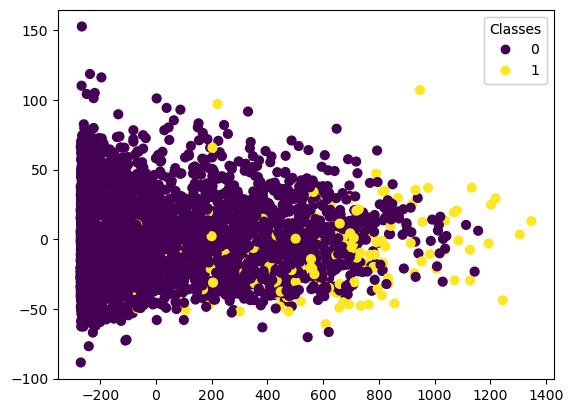

In [38]:
# Displaying x1 and x2 from PCA with "hof" colors
fig, ax = plt.subplots()
scatter = ax.scatter(df_pca['x1'],df_pca['x2'],c=y,s=40)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),title="Classes")
ax.add_artist(legend1)
plt.show()

#### K-Means Clustering

In [39]:
# Applying K-Means Clsutering with 2 clusters
kmeans = KMeans(n_clusters = 2)
kmeans.fit(df_pca)

KMeans(n_clusters=2)

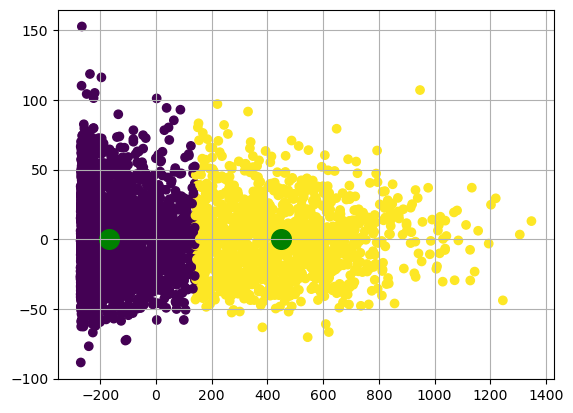

centers:  [[-1.69856407e+02 -3.54929068e-02]
 [ 4.50104499e+02  9.40530731e-02]]


In [40]:
# Displaying K-Means clusters and centers
plt.scatter(df_pca['x1'],df_pca['x2'],c=kmeans.labels_,label=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=200,c='green')
plt.grid(True)
plt.show()
print("centers: ",kmeans.cluster_centers_)

#### DBScan

In [41]:
epsilon = 100
min_samples = 500
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(df_pca)
labels = db.labels_
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 1160


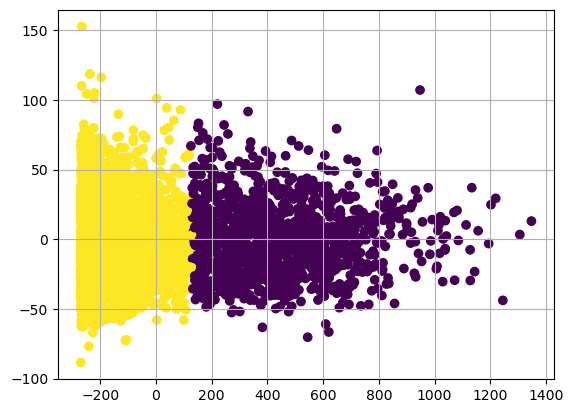

In [42]:
# Displaying DBScan clusters
plt.scatter(
    df_pca['x1'],
    df_pca['x2'],
    c=db.labels_,
    label=db.labels_)
plt.grid(True)
plt.show()

### Next Hall of Famers

In [43]:
# Predicting who will be the next Hall of Famers
# generating DataFrame of active and recently retired players
nexts = clean.loc[clean["To"] > 2018]
nexts.head()

,Player,From,To,Years,Pos,Ht,Height,Wt,G,PTS,TRB,AST,FG%,FG3%,FT%,eFG%,PER,WS,All Star,All NBA,All ABA,All Rookie,All Defensive,BLK Champ,STL Champ,TRB Champ,AST Champ,Scoring Champ,Most Improved,Sixth Man,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team
9,Álex Abrines,2017,2019,3,G-F,6-6,6.500000,200.0,174,5.3,1.4,0.5,38.7,36.8,88.0,52.5,8.8,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Precious Achiuwa,2021,2022,2,F,6-8,6.666667,225.0,134,7.2,5.1,0.8,46.8,35.7,55.6,50.2,13.1,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,Quincy Acy,2013,2019,7,F-C,6-7,6.583333,240.0,337,4.9,3.5,0.6,44.4,35.0,75.9,51.3,11.2,8.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,Jaylen Adams,2019,2021,3,G,6-0,6.000000,225.0,41,2.7,1.5,1.6,33.1,32.9,77.8,43.6,7.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,Steven Adams,2014,2022,9,C,6-11,6.916667,265.0,664,9.3,8.0,1.5,58.7,7.1,54.7,58.7,17.0,56.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
# Preproccesing nexts' DataFrame data
nexts["All NBA/ABA"] = nexts["All NBA"] + nexts["All ABA"]
nexts = pd.get_dummies(nexts, columns=["Pos"])
nexts = nexts.drop(columns=["To", "Ht", "All NBA", "All ABA"])
nexts_x = nexts.drop(columns=["Player"])
nexts_x = std_scaler.fit_transform(nexts_x)

In [45]:
# Adding positive prediction probabilities
nexts["Basic RFC"] = rfc_clf.predict_proba(nexts_x)[:, 1]
nexts["GridSearch RFC"] = rfc_gscv.predict_proba(nexts_x)[:, 1]
nexts["Resampled RFC"] = resampled_rfc_clf.predict_proba(nexts_x)[:, 1]
nexts["Basic SVC"] = svc_clf.predict_proba(nexts_x)[:, 1]
nexts["GridSearch SVC"] = svc_gscv.predict_proba(nexts_x)[:, 1]
nexts["Resampled SVC"] = resampled_svc_clf.predict_proba(nexts_x)[:, 1]

In [46]:
# Displaying Top 5 predictions of each estimator
print("Basic RFC")
base_rfc_top5 = nexts.sort_values("Basic RFC", ascending=False).head()
print(base_rfc_top5[["Player", "Basic RFC"]])
print()
print("GridSearch RFC")
base_rfc_top5 = nexts.sort_values("GridSearch RFC", ascending=False).head()
print(base_rfc_top5[["Player", "GridSearch RFC"]])
print()
print("Resampled RFC")
base_rfc_top5 = nexts.sort_values("Resampled RFC", ascending=False).head()
print(base_rfc_top5[["Player", "Resampled RFC"]])
print()
print("Basic SVC")
base_rfc_top5 = nexts.sort_values("Basic SVC", ascending=False).head()
print(base_rfc_top5[["Player", "Basic SVC"]])
print()
print("GridSearch SVC")
base_rfc_top5 = nexts.sort_values("GridSearch SVC", ascending=False).head()
print(base_rfc_top5[["Player", "GridSearch SVC"]])
print()
print("Resampled SVC")
base_rfc_top5 = nexts.sort_values("Resampled SVC", ascending=False).head()
print(base_rfc_top5[["Player", "Resampled SVC"]])

Basic RFC
                 Player  Basic RFC
4597        Dwyane Wade       1.00
1793       James Harden       1.00
961       Stephen Curry       0.97
4738  Russell Westbrook       0.97
2028      Dwight Howard       0.97

GridSearch RFC
                 Player  GridSearch RFC
2155       LeBron James           0.994
1793       James Harden           0.992
4597        Dwyane Wade           0.988
1199       Kevin Durant           0.988
4738  Russell Westbrook           0.986

Resampled RFC
             Player  Resampled RFC
961   Stephen Curry           0.73
4597    Dwyane Wade           0.73
1199   Kevin Durant           0.70
2155   LeBron James           0.70
3462     Chris Paul           0.70

Basic SVC
               Player  Basic SVC
2704       Kyle Lowry   0.994274
216        J.J. Barea   0.993700
1346   Raymond Felton   0.982765
1652      Danny Green   0.975306
302   Marco Belinelli   0.974321

GridSearch SVC
               Player  GridSearch SVC
4597      Dwyane Wade             1.